# Topic identification with Top2Vec

## Import and Setup

### 1. Import libraries

In [ ]:
# Basic data processing
from collections import defaultdict
import pickle
import pandas as pd

# Logging
from loguru import logger
from tqdm import tqdm; tqdm.pandas()

# Text preprocessing
import re
import string
import nltk
for dependency in ['punkt', 'wordnet', 'omw-1.4', 'stopwords', 'averaged_perceptron_tagger']:
    nltk.download(dependency, quiet=True)

# hSBM model
import graph_tool.all as gt
from hSBM.sbmtm import sbmtm

### 2. Function for preprocessing text

In [ ]:
def preprocess(text):
    # Lowercasing words
    text = text.lower()
    
    # Removing HTML tag
    text = re.sub(r'&amp', '', text)

    # Replace "&" with "and"
    text = re.sub(r'&','and', text)
    
    # Removing mentions 
    text = re.sub(r'@\w+ ', '', text)
    
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation.replace('-',''))) # Taking hyphens out of punctuation to remove
    text = re.sub(r' - ','', text) # Removing dash lines bounded by whitespace (and therefore not part of a word)
    text = re.sub(r'[‘’“”—]','',text) # Removing punctuation that is not captured by string.punctuation
    
    # Removing 'RT' and 'via'
    text = re.sub(r'(^rt|^via)((?:\\b\\W*@\\w+)+): ', '', text)
    
    # Removing odd special characters
    text = re.sub(r"[┻┃━┳┓┏┛┗]","", text)
    text = re.sub(r"\u202F|\u2069|\u200d|\u2066","", text)
    
    # Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    # Removing numbers
    text = re.sub(r'[0-9.]','', text)
    
    # Removing idiosynchratic characters 
    text = re.sub(r'-\n|\n-|\na-|\nb-|–|«|--', '', text)
    text = re.sub(r'- ', ' ', text)

    # Removing separators and superfluous whitespace
    text = text.strip()
    text = re.sub(r' +',' ',text)

    # Tokenizing
    tokenizer = nltk.TweetTokenizer() 
    tokens = tokenizer.tokenize(text)

    # Lemmatizing
    tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)
    tag_map['J'] = nltk.corpus.wordnet.ADJ
    tag_map['V'] = nltk.corpus.wordnet.VERB
    tag_map['R'] = nltk.corpus.wordnet.ADV    
    
    lemmatizer = nltk.WordNetLemmatizer()             
    text_lemmatized = []                           

    for word, tag in nltk.pos_tag(tokens):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
        text_lemmatized.append(lemma)
    
    tokens = text_lemmatized  
    
    # Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    tokens = [i for i in tokens if i not in stop_words_list]

    # Including bigrams
    bigrams = ["_".join(bigram) for bigram in nltk.bigrams(tokens)]
    tokens.extend(bigrams)

    return tokens

### 3. Load data

In [ ]:
with open('../Data/df_tweets_selected_users_after_oct.p', 'rb') as f:
    tweets_df = pickle.load(f)
logger.info(f'Loaded {len(tweets_df)} tweets')

texts_raw = tweets_df.text.reset_index(drop=True)                        # Raw tweets

logger.info('Preprocessing tweets')
texts_processed = texts_raw.progress_apply(preprocess).drop_duplicates() # Preprocessed tweets
logger.info(f'Reduced to {len(texts_processed)} unique tweets')

texts = texts_processed.to_list()                                        # Preprocessed tweets as list   
titles = [str(i) for i in range(len(texts))]                             # New index for each tweet    

# Fitting the model
In this section, we fit the hSBM to the data. With the current parameter settings, this takes about minutes on our machines.
Parameters:
  * ``n_min``: All tokens with less than `n_min` number of occurrences in the corpus will be filtered.

  * ``n_init``: Number of different initial conditions to try.

  * ``niter``: Number of sweeps to perform. During each sweep, a move attempt is made for each node, on average.

  * ``merge_sweeps``: Number of sweeps spent to find good merge proposals.
  
  * ``mh_sweeps``:  Number of single-node Metropolis-Hastings sweeps between merge splits.

  * ``gibbs``: If `True`, the single node moves use (slower) Gibbs sampling, rather than Metropolis-Hastings.

See [topsbm documentation](https://topsbm.readthedocs.io/_/downloads/en/stable/pdf/) as well as documentation for [`minimize_nested_blockmodel_dl`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.minimize_nested_blockmodel_dl) and [`multilevel_mcmc_sweep`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.MultilevelMCMCState.multilevel_mcmc_sweep)

In [ ]:
# Create instance of sbmtm class
model = sbmtm()

# Make graph from texts
model.make_graph(texts, 
                 documents=titles,
                 n_min=2)

# Fit the model
gt.seed_rng(32) # Random seed to ensure identical results
logger.info('Fitting hSBM model')
model.fit(n_init=1,
          niter=2,
          merge_sweeps=25,
          mh_sweeps=25,
          gibbs=False) 
logger.info('Model finished')

# Save the model
logger.info('Saving model to pickle file')
#model.save_model('Models & outputs/hsbm_model')

## Analysis

### 1. Load model
If the model was not fitted in the above code, it can be loaded from a pickle file.

In [15]:
model = sbmtm()
model.load_model('Models & outputs/hsbm_model')

### 2. Visual inspection of model

We can visually inspect the the model by plotting the hierarchical tree structure implied by the model. Each blue square represents a group–document-groups are on the left and word-groups (topics) are on the right side of the plot. At the highest hierarchical level, there is just one overarching topic, representing the whole corpus. This topic splits up into 7 subtopics within which 26 topics are embedded. At the most granular level, words are grouped into 112 different topics. 

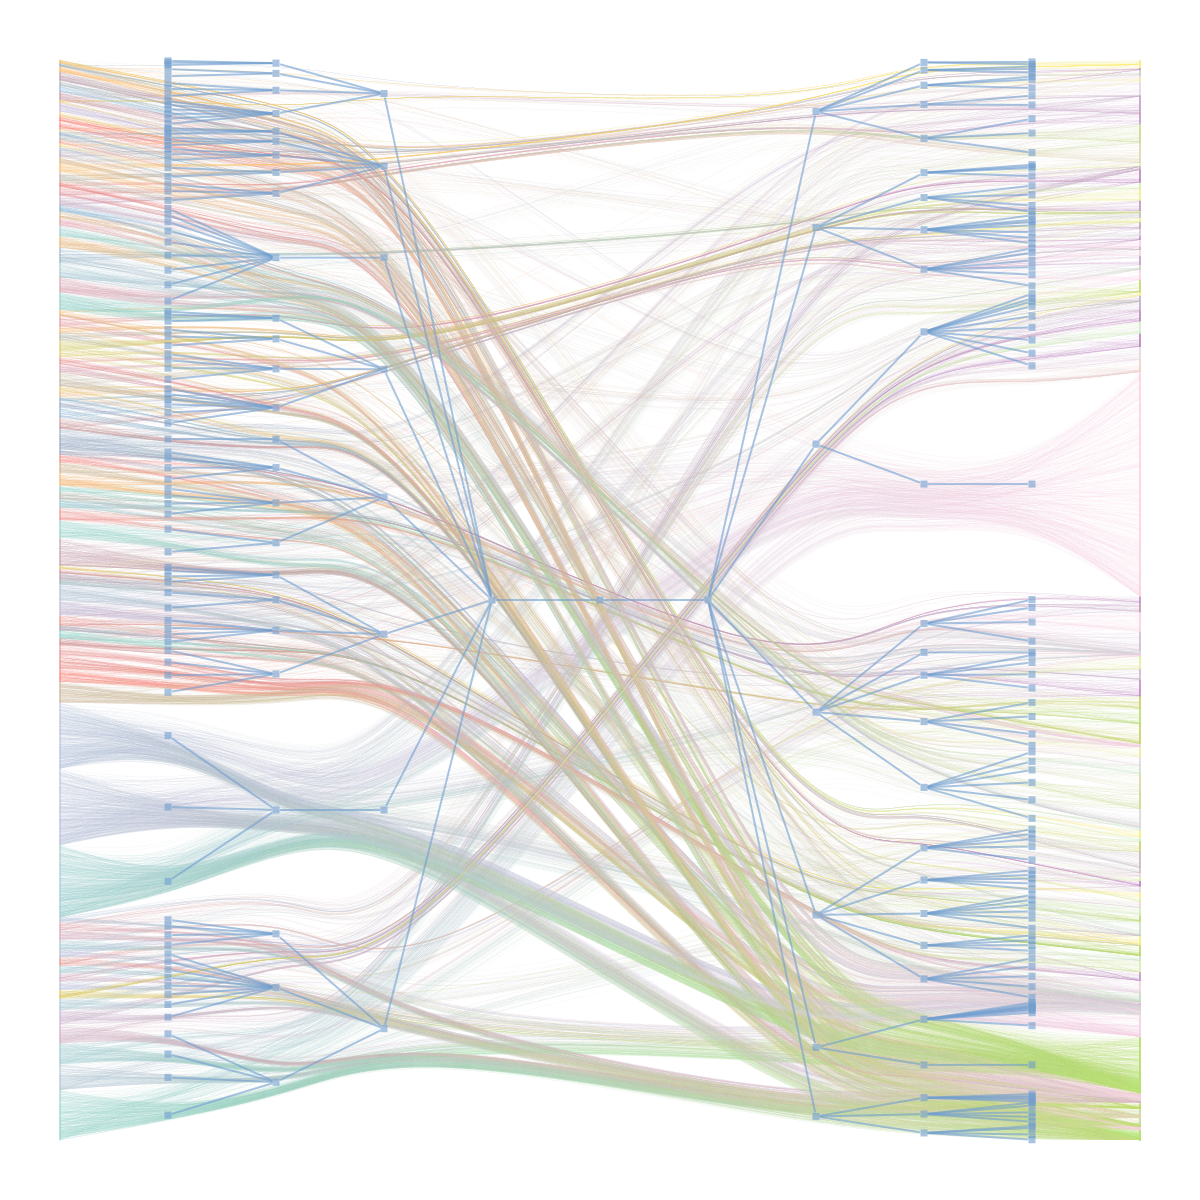

In [16]:
model.plot(nedges=10000)

### 3. Examining topics (word groups)


In [17]:
# Pick word-group level to examined
level = 1

In [18]:
# Sums of topic probabilities over documents
topic_sums = model.get_groups(l=level)['p_tw_d'].sum(axis=1)

# Sort topics by largest summed prob given docs
topic_sums_sorted = sorted(
    [(i, topic_sum) for i, topic_sum in enumerate(topic_sums)],
    key=lambda x: x[1],
    reverse=True
)

In [20]:
n_tokens = 20   # Number of tokens per topic to display
n_docs = 10     # Number of representative documents per token to display

# Define function for printing and writing output
def print_and_write(file, string):
    '''Prints string to output and writes it to a text file'''
    print(string)
    f.write(string+"\n")

# Find top tokens and representative tweets for each topic 
f = open('Models & outputs/hsbm_topics.txt', 'w')

topics_words = model.topics(l=level, n=n_tokens) # Dict containing top n_tokens tokens for each topic
for topic_num, (i, topic_sum) in enumerate(topic_sums_sorted, 1):    
    print_and_write(f, 'Topic '+str(topic_num))
    print_and_write(f, 'Sum(p_tw_d):  '+str(topic_sum))
    print_and_write(f, 32*'-')
    print_and_write(f, '{:<25s}{}'.format('Token', 'Prob'))
    for token, prob in topics_words[i]:
        print_and_write(f, '{:<25s}{:.5f}'.format(token, prob))
    print_and_write(f, 32*'-')
    print_and_write(f, 'Representative documents')
    representative_docs = sorted(                 # Tweets with highest topic probability for given topic
        [(i, prob) for i, prob in enumerate(model.get_groups(l=level)['p_tw_d'][i])],
        key=lambda x: x[1],
        reverse=True
    )[:n_docs]
    for j, prob in representative_docs:
        print_and_write(f, texts_raw[texts_processed.index[j]]) # texts_processed.index[j] converts new index 
                                                                # (after removing duplicates) to old index (before removing duplicates) 
        print_and_write(f, "-----")                             
    print_and_write(f, 32*'-')
    print_and_write(f, '\n')

f.close()

Topic 1
Sum(p_tw_d):  573.9552388397766
--------------------------------
Token                    Prob
nuclear                  0.35772
eu                       0.16881
european                 0.06770
say                      0.02902
support                  0.01251
policy                   0.01098
via                      0.00972
help                     0.00905
union                    0.00779
give                     0.00719
european_union           0.00719
week                     0.00712
issue                    0.00686
read                     0.00679
future                   0.00652
report                   0.00632
move                     0.00612
news                     0.00533
continue                 0.00519
push                     0.00506
--------------------------------
Representative documents
Venn diagram of the EU nuclear debate https://t.co/w6rH0RTDN8
-----
My statement for @workersparty about EU nuclear energy policy https://t.co/VR1mdM0CS0
-----
Met with @rafaelmgr